# Fitting routines

For all methods, the underlying package LMFIT handles the parabolic error calculations and passes along the optimization assignment to SciPy.

## Chisquare method

When fitting with the chisquare method, the costfunction to be minimized is

$$\chi^2 = \left(\frac{y_i-HFS(x_i)}{\sigma_i}\right)^2$$

with the subscript *i* referring to the datapoint, and *HFS* to the response of the :class:`.HFSModel` class. The algorithm used is the Levenberg-Marquardt algorithm, which gives quick results in a reliable fashion. The :func:`.fitting.chisquare_model` function creates the costfunction used for counting data. The function :func:`.fitting.chisquare_fit` performs the actual fit, while :func:`.fitting.chisquare_spectroscopic_fit` calculates the uncertainty on the data by taking the square root of the number of counts.

One of the options for :func:`.fitting.chisquare_model` is the keyword *func*. This applies the given function to the *fitvalue* to calculate the uncertainty on the datapoint. Setting this to the square root function mimics the use of the Poisson distribution instead of the Gaussian distribution for the uncertainty calculation.

In order to demonstrate the fit functions, toy data is needed. This is created by assuming some parameters for the basemodel, calculating the response, and then adding random noise.

C:\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Chisquare fitting done: 126it [00:00, 787.45it/s]                      


True
Tolerance seems to be too small.
NDoF: 191, Chisquare: 204.74572, Reduced Chisquare: 1.0719671
Errors not scaled with reduced chisquare.
[[Variables]]
    FWHMG:         11.4052935 +/- 2.725368 (23.90%) (init= 11.40556)
    FWHML:         8.04020575 +/- 2.450075 (30.47%) (init= 8.040089)
    TotalFWHM:     16.3017438 +/- 1.350493 (8.28%)  == '0.5346*FWHML+(0.2166*FWHML**2+FWHMG**2)**0.5'
    Scale:         97.0923210 +/- 6.671103 (6.87%) (init= 97.09159)
    Saturation:    0 (fixed)
    Amp0__1:       0.2380726 (fixed)
    Amp1__1:       0.1786341 (fixed)
    Amp1__2:       0.535743 (fixed)
    Amp2__1:       0.01191064 (fixed)
    Amp2__2:       0.1786448 (fixed)
    Amp2__3:       1 (fixed)
    Al:            98.4456970 +/- 0.927711 (0.94%) (init= 98.44472)
    Au:            199.024103 +/- 0.568696 (0.29%) (init= 199.0234)
    Bl:            101.250852 +/- 0.636955 (0.63%) (init= 101.2501)
    Bu:            200.908034 +/- 0.963296 (0.48%) (init= 200.9071)
    Cl:            0 

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


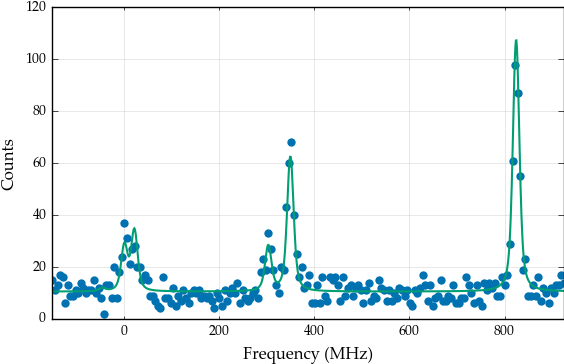

(<matplotlib.figure.Figure at 0xbd83b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0xbda6eb8>)

In [1]:
%matplotlib inline

import satlas as s
import numpy as np
s.set()
np.random.seed(0)  #Ensure the same random numbers each time

I = 1.0
J = [1.0, 2.0]

ABC = [100, 200, 100, 200, 0, 0]
fwhm = [10, 10]
centroid = 500
scale = 100

basemodel = s.HFSModel(I, J, ABC, centroid, fwhm=fwhm, scale=scale, background_params=[10], use_racah=True)

frequency_range = (min(basemodel.locations) - 100, max(basemodel.locations) + 100)
frequency_range = np.linspace(frequency_range[0], frequency_range[1], 200)

data = np.floor(basemodel(frequency_range) + basemodel(frequency_range)**0.5 * np.random.randn(len(frequency_range)))

success, message = s.chisquare_spectroscopic_fit(basemodel, frequency_range, data)
print(success)
print(message)
basemodel.display_chisquare_fit(show_correl=False)
basemodel.plot(x=frequency_range, y=data)

If *func=np.sqrt* is given to the fitfunction, the result is

Chisquare fitting done: 169it [00:00, 778.76it/s]                       


True
Tolerance seems to be too small.
NDoF: 191, Chisquare: 204.74572, Reduced Chisquare: 1.0719671
Errors not scaled with reduced chisquare.
[[Variables]]
    FWHMG:         11.4046732 +/- 2.725470 (23.90%) (init= 11.40435)
    FWHML:         8.04079652 +/- 2.450016 (30.47%) (init= 8.040948)
    TotalFWHM:     16.3015559 +/- 1.350555 (8.28%)  == '0.5346*FWHML+(0.2166*FWHML**2+FWHMG**2)**0.5'
    Scale:         97.0921175 +/- 6.671372 (6.87%) (init= 97.09294)
    Saturation:    0 (fixed)
    Amp0__1:       0.2380726 (fixed)
    Amp1__1:       0.1786341 (fixed)
    Amp1__2:       0.535743 (fixed)
    Amp2__1:       0.01191064 (fixed)
    Amp2__2:       0.1786448 (fixed)
    Amp2__3:       1 (fixed)
    Al:            98.4445375 +/- 0.927717 (0.94%) (init= 98.4456)
    Au:            199.023681 +/- 0.568704 (0.29%) (init= 199.0244)
    Bl:            101.251172 +/- 0.636961 (0.63%) (init= 101.252)
    Bu:            200.907484 +/- 0.963299 (0.48%) (init= 200.9086)
    Cl:            0 (f

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


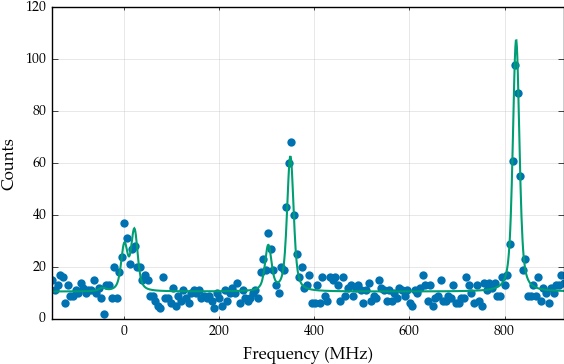

(<matplotlib.figure.Figure at 0xc60bf98>,
 <matplotlib.axes._subplots.AxesSubplot at 0xc692e48>)

In [2]:
basemodel = s.HFSModel(I, J, ABC, centroid, fwhm=fwhm, scale=scale, background_params=[50], use_racah=True)
success, message = s.chisquare_spectroscopic_fit(basemodel, frequency_range, data, func=np.sqrt)
print(success)
print(message)
basemodel.display_chisquare_fit(show_correl=False)
basemodel.plot(x=frequency_range, y=data)

which is slightly different.

## Maximum Likelihood Estimation

The Maximum Likelihood Estimation (MLE) can be used to derive the chisquare method in the case of Gaussian uncertainties. When this is not the case (as it is for counting data, which has a Poisson distribution), a less simplified method has to be used.

The MLE method works by minimizing the negative loglikelihood. This is calculated as

$$-\mathcal{L}\left(\vec{\theta}\middle|x, y, \sigma\right) = \sum_i logp\left(\vec{\theta}\middle|x_i, y_i, \sigma_i\right)$$

For the function *logp*, the standard choice is the loglikelihood derived from the Poisson distribution.

To use this method, the fitting routine code has to be changed to

Likelihood fitting done: 14272it [00:16, 883.50it/s]                        
Finished Hessian calculation: 7it [00:02,  2.79it/s]


True
Converged (|f_n-f_(n-1)| ~= 0)
Chisquare: 215.421, Reduced Chisquare: 1.1278587
Errors not scaled with reduced chisquare.
[[Variables]]
    FWHMG:         9.97180008 +/- 2.910081 (29.18%) (init= 9.947739)
    FWHML:         9.19832891 +/- 2.387925 (25.96%) (init= 9.21375)
    TotalFWHM:     15.7693002  == '0.5346*FWHML+(0.2166*FWHML**2+FWHMG**2)**0.5'
    Scale:         98.7987160 +/- 6.615152 (6.70%) (init= 98.78897)
    Saturation:    0 (fixed)
    Amp0__1:       0.2380726 (fixed)
    Amp1__1:       0.1786341 (fixed)
    Amp1__2:       0.535743 (fixed)
    Amp2__1:       0.01191064 (fixed)
    Amp2__2:       0.1786448 (fixed)
    Amp2__3:       1 (fixed)
    Al:            98.2629580 +/- 0.839243 (0.85%) (init= 98.27085)
    Au:            198.911295 +/- 0.517327 (0.26%) (init= 198.9112)
    Bl:            101.468935 +/- 0.677627 (0.67%) (init= 101.4623)
    Bu:            201.092174 +/- 0.887771 (0.44%) (init= 201.2572)
    Cl:            0 (fixed)
    Cu:            0 (fixed)


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


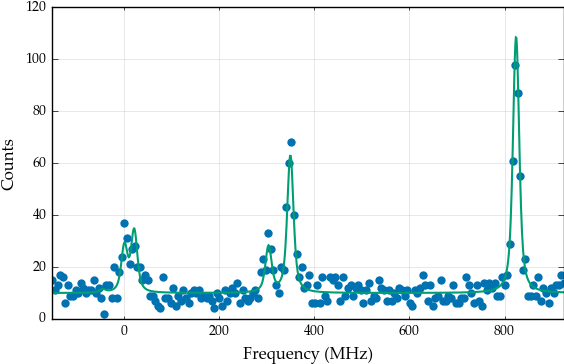

(<matplotlib.figure.Figure at 0xd9042e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0xc7b1860>)

In [ ]:
basemodel = s.HFSModel(I, J, ABC, centroid, fwhm=fwhm, scale=scale, background_params=[10], use_racah=True)
success, message = s.likelihood_fit(basemodel, frequency_range, data)
print(success)
print(message)
basemodel.display_mle_fit(show_correl=False)
basemodel.plot(x=frequency_range, y=data)

The uncertainties on the parameters can be estimated using a random walk through parameter space, or the analytical boundaries can be calculated. The random walk is explained in another tutorial. To estimate the analytical bounds:

In [ ]:
s.calculate_analytical_uncertainty(basemodel, frequency_range, data, method='mle')
basemodel.display_mle_fit(show_correl=False)

FWHMG (finding root): 5it [00:42,  7.58s/it]                  

By supplying a list of names under the *filter* keyword, the uncertainty on only certain parameters can be estimated.

Note that, due to the fact that a fit is performed for every calculated value for a parameter, the numbers given as the best fit might change slightly. Convergence is also not guaranteed, so warning messages might be displayed for some parameters.

# Fitting with literature values

When using the :meth:`.BaseModel.set_literature_values` method to take the known literature values into account, the fitting statistic is adjusted in the following way:
1. The chisquare calculation automatically adds the literature value as an extra datapoint, correctly incorporating this in the calculation of the degrees of freedom. The new chisquare formula is
$$\chi^2 = \sum_i \left(\frac{y_i-f\left(x_i\right)}{\sigma_i}\right)^2 + \sum_{params} \left(\frac{p_{lit}-p_{fit}}{\sigma_{lit}}\right)^2$$
1. In the likelihood calculation, a Gaussian prior for the specified parameters is used instead of a uniform one.

These methods are equivalent in the case of Gaussian distributions on the datapoints for the likelihood calculation.


# Likelihood reduced chisquare calculation

In the case of the likelihood calculations, deriving a statistic like the $\chi^2_{red}$ is not as straightforward. One possibility is using $$\chi^2_{\mathcal{L}} = -2\mathcal{L}\left(y_i, f\left(x_i\right)\right)+2\mathcal{L}\left(y_i, y_i\right)
$$ and this is also what is implemented in SATLAS